## AIPI 590 - XAI | Assignment #8
### XAI In LLMs
#### Author: Tal Erez
#### Colab Notebook:
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/notthattal/Explainable_LLMs/blob/main/explainable_llms.ipynb)

### To Run in Colab

Verify you are running on a GPU. On the top right of the screen click the down arrow in between "RAM/Disk" and "Gemini"  -> Change Runtime Type -> T4 GPU -> Save

### Introduction
This notebook uses the MedEmbed-small-v0.1 model found on MTEB and runs tSNE, UMAP and PCA to visualize the embedding space of the model. The goal of these visualizations is to see if we can derive relationships between the questions being asked in medical entrance exams and their corresponding subfield of study. The MedEmbed model is a family of embedding models fine-tuned specifically for medical and clinical data, designed to enhance performance in healthcare-related natural language processing (NLP) tasks, particularly information retrieval (Balachandran). The dataset used to create the embeddings is OpenLifeScienceAI's medmcqa dataset. This dataset consists of medical entrance exam questions and answers for a variety of different subfields of medicine.

### Install required dependencies and import packages

In [ ]:
import os

# Remove Colab default sample_data if it exists
if os.path.exists("./sample_data"):
    !rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable_LLMs"

# Check if the repo already exists
if not os.path.exists("/content/" + repo_name):
    git_path = 'https://github.com/notthattal/Explainable_LLMs.git'
    !git clone "{git_path}"
else:
    print(f"{repo_name} already exists.")

# Change working directory to location of notebook
path_to_notebook = os.path.join("/content/" + repo_name)
%cd "{path_to_notebook}"

!pip install -r requirements.txt

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_DISPLAY_ENV"] = "FALSE"

### Load the Model and Dataset

In [13]:
# retrieve the model and dataset
model = SentenceTransformer("abhinand/MedEmbed-small-v0.1")
dataset = load_dataset("openlifescienceai/medmcqa")

# a list of the columns containing the answer options for each question
options = ['opa', 'opb', 'opc', 'opd']

# convert dataset to df
df = dataset["train"].to_pandas()

# cop is the answer column (0-3 inclusive corresponding to answer letters a-d, respectively)
# converts the answer column from the numeric answer to the string answer
df['cop'] = df.apply(lambda row: row[options[row['cop']]], axis=1)

# retrieves only the columns relevant to creating the visualizations
df = df[['question', 'cop', 'subject_name']]

### Create the Base Embeddings

In [14]:
# retrieve a sample of rows from the df
df_sample = df.iloc[:10000]

# get the embeddings from the model
embeddings = model.encode(df_sample['question'].to_list())

### Create Visualization Functions

In [15]:
def plot_embeddings_3D(embeddings, values_df, method_name):
    '''
    This function creates the 3D rendering of embeddings

    Inputs:
        - embeddings (numpy.ndarray): the embeddings to render
        - values_df (pd.Dataframe): the dataframe for which to retrieve the questions, answers and medical subjects
        - method_name (str): The name of the method used to update labels (i.e. tSNE, UMAP or PCA)
    '''
    # create the plot dataframe from the embeddings
    plot_df = pd.DataFrame(embeddings, columns=[method_name + '1', method_name + '2', method_name + '3'])
    # add the questions, answers and subjects to the new df
    plot_df['question'] = "Question: " + values_df['question'].values
    plot_df['answer'] = "Answer: " + values_df['cop'].values
    plot_df['subject'] = values_df['subject_name'].values

    # get the unique colors for each subject
    unique_subjects = plot_df['subject'].unique()
    colors = np.concatenate([plt.cm.tab20(np.linspace(0, 1, 20)), plt.cm.tab20b(np.linspace(0, 1, 21 - 20))])

    # convert colors to hex
    color_hex = [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b, _ in colors]

    # map each unique subject to a specific color
    color_map = {subject: color_hex[i] for i, subject in enumerate(unique_subjects)}

    # create the title text displayed when hovering over a dot
    plot_df['hover_text'] = plot_df['question'] + "<br>" + plot_df['answer']

    # Create the interactive 3D scatter plot with custom colors
    fig = px.scatter_3d(
    plot_df,
    x=method_name + '1',
    y=method_name + '2',
    z=method_name + '3',
    color='subject',
    hover_name='hover_text',
    title="Interactive 3D " + method_name + " Plot of Medical Questions by Subject",
    color_discrete_map=color_map
    )

    # set the size of the points
    fig.update_traces(
        marker=dict(size=5)
    )

    # create the legend, label the axes and set the hover text font-size
    fig.update_layout(
        legend_title_text="Subject Categories",
        scene=dict(
            xaxis_title=method_name + 'Dimension 1',
            yaxis_title=method_name + 'Dimension 2',
            zaxis_title=method_name + 'Dimension 3'
        ),
        hoverlabel=dict(
            font_size=10,
        ),
    )

    # render the 3D plot
    fig.show(renderer='notebook')
    fig.write_html('./3D_Graphs/' + method_name + '_3D.html')

def plot_embeddings_2D(embeddings, values_df, method_name):
    '''
    This function creates the 2D rendering of embeddings

    Inputs:
        - embeddings (numpy.ndarray): the embeddings to render
        - values_df (pd.Dataframe): the dataframe for which to retrieve the questions, answers and medical subjects
        - method_name (str): The name of the method used to update labels (i.e. tSNE, UMAP or PCA)
    '''
    # create the plot dataframe from the embeddings
    plot_df = pd.DataFrame(embeddings, columns=[method_name + '1', method_name + '2'])
    plot_df['subject'] = values_df['subject_name'].values
    
    # get the unique colors for each subject
    unique_subjects = plot_df['subject'].unique()
    colors = np.concatenate([plt.cm.tab20(np.linspace(0, 1, 20)), plt.cm.tab20b(np.linspace(0, 1, len(unique_subjects) - 20))])

    # convert the colors to hex
    color_hex = [f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' for r, g, b, _ in colors]

    # map each unique subject to a specific color
    color_map = {subject: color_hex[i] for i, subject in enumerate(unique_subjects)}

    # create the figure
    plt.figure(figsize=(10, 8))

    # add each subjects points to the final scatter plot with the correct coloring
    for subject in unique_subjects:
        subset = plot_df[plot_df['subject'] == subject]
        plt.scatter(subset[method_name + '1'], subset[method_name + '2'], label=subject, color=color_map[subject], s=10)

    # plot the 2D visualization and show the legend along side it
    plt.title("2D " + method_name + " Plot of Medical Questions by Subject")
    plt.xlabel(method_name + " Dimension 1")
    plt.ylabel(method_name + " Dimension 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig('./2D_Graphs/' + method_name + '_2D.png', bbox_inches='tight')
    plt.show()

### *Visualization Notes:*
- The following functions will take a while to produce the visualizations. 2D visualizations should already be present below. If you would like to view 3D visualizations without waiting, there are pre-loaded ones under the 3D_Graphs folder.
- If zooming capabilities seem slow on track pad, do not try and pinch to zoom. Use scroll zoom by swiping up or down

### tSNE

Creates 2D and 3D tSNE embeddings and plots the corresponding visualizations


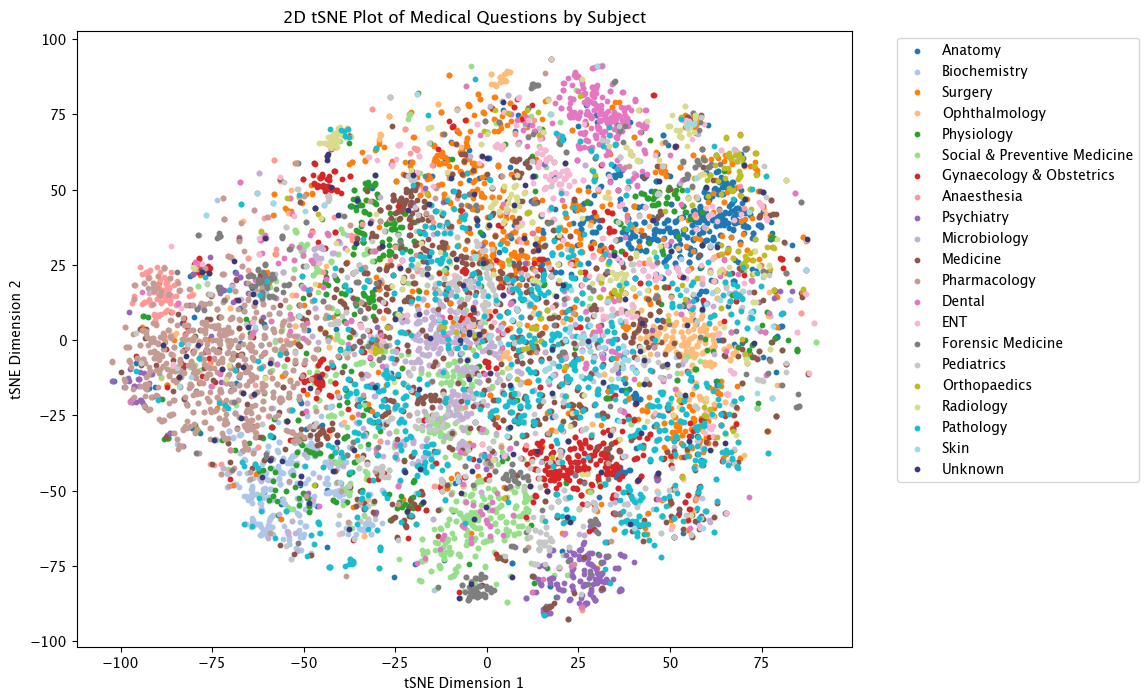

In [16]:
# create 2D tSNE instance
tsne_2D = TSNE(n_components=2, random_state=42)

# get the 2D embeddings
embeddings_tsne_2D = tsne_2D.fit_transform(embeddings)

# plot the 2D embeddings
plot_embeddings_2D(embeddings_tsne_2D, df_sample, 'tSNE')

In [ ]:
# create 3D tSNE instance
tsne_3D = TSNE(n_components=3, random_state=42)

# get the 3D embeddings
embeddings_tsne_3D = tsne_3D.fit_transform(embeddings)

# plot the 3D embeddings
plot_embeddings_3D(embeddings_tsne_3D, df_sample, 'tSNE')

### UMAP

Creates 2D and 3D UMAP embeddings and plots the corresponding visualizations

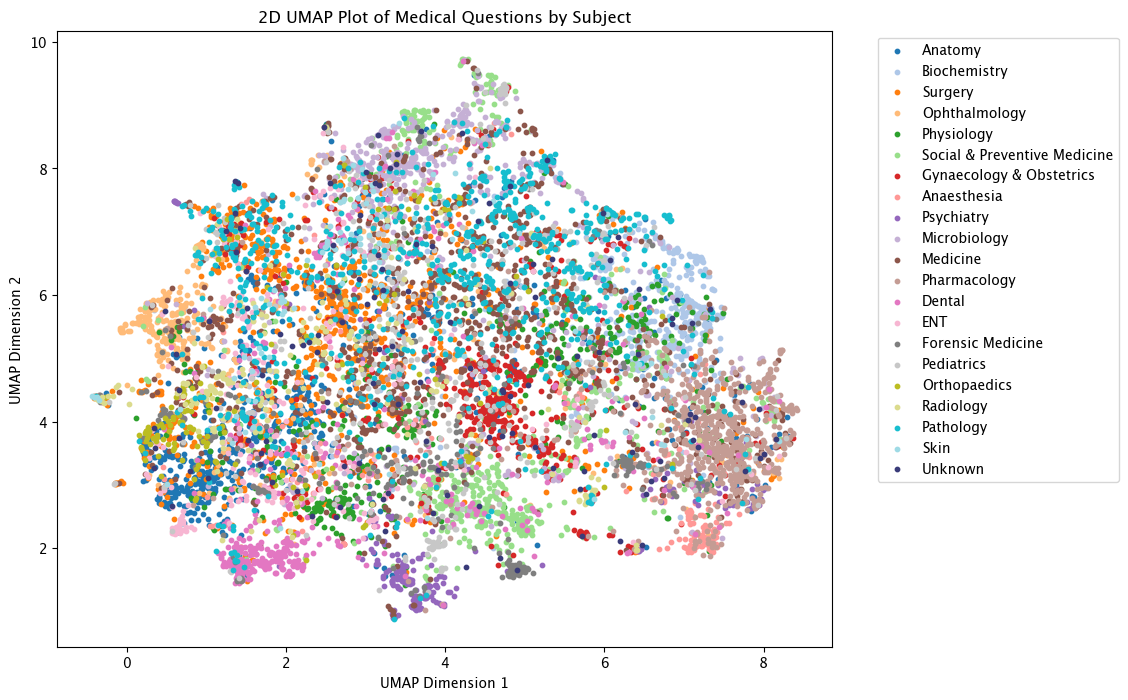

In [18]:
# create 2D UMAP instance
umap_2D = umap.UMAP(n_components=2)

# get 2D embeddings
embeddings_umap_2D = umap_2D.fit_transform(embeddings)

# plot the 2D embeddings
plot_embeddings_2D(embeddings_umap_2D, df_sample, 'UMAP')

In [ ]:
# create 3D UMAP instance
umap_3D = umap.UMAP(n_components=3)

# get 3D embeddings
embeddings_umap_3D = umap_3D.fit_transform(embeddings)

# plot the 3D embeddings
plot_embeddings_3D(embeddings_umap_3D, df_sample, 'UMAP')

### PCA

Creates 2D and 3D PCA embeddings and plots the corresponding visualizations

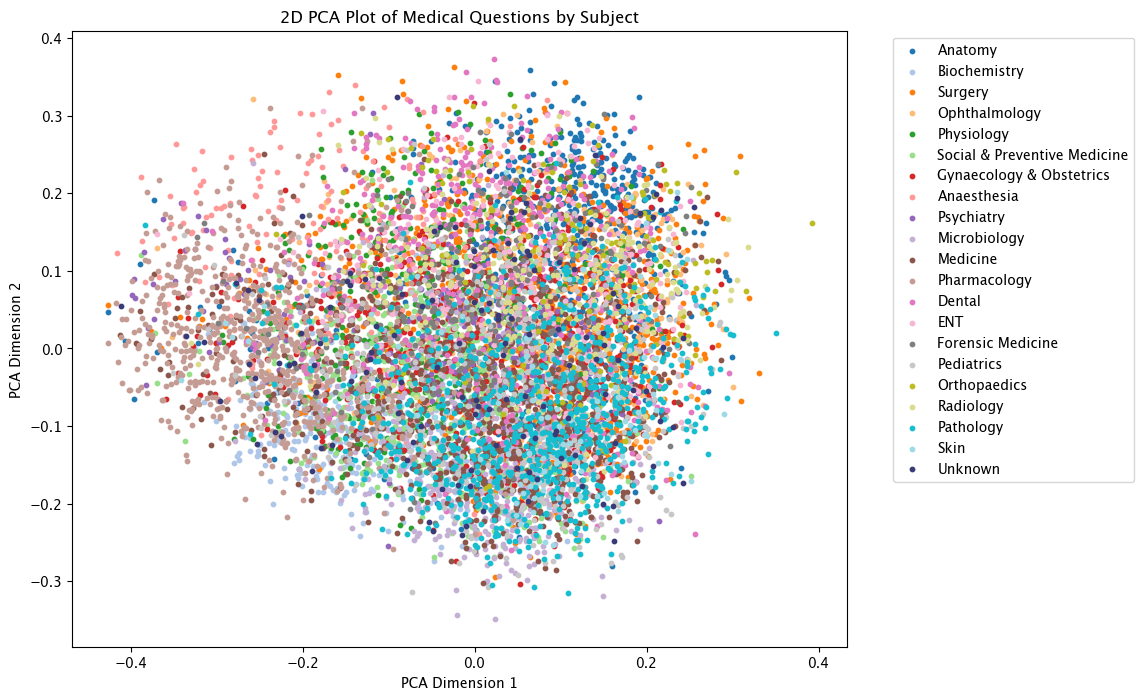

In [9]:
# create 2D PCA instance
pca_2D = PCA(n_components=2)

# get 2D embeddings
embeddings_pca_2D = pca_2D.fit_transform(embeddings)

# plot the 2D embeddings
plot_embeddings_2D(embeddings_pca_2D, df_sample, 'PCA')

In [ ]:
# create 3D PCA instance
pca_3D = PCA(n_components=3)

# get 3D embeddings
embeddings_pca_3D = pca_3D.fit_transform(embeddings)

# plot the 3D embeddings
plot_embeddings_3D(embeddings_pca_3D, df_sample, 'PCA')

### Discussion: tSNE vs UMAP vs PCA
- ***PCA:*** Running PCA over 10,000 samples was the most computationally efficient method compared to the prior two. However, while clusters are present in PCA, we can see in both the 2D and 3D graphs that the points are more evenly distributed amongst themselves. Without the other two methods for comparison, PCA may lead us to believe the questions have a weak relationship to each other. 

- ***tSNE:*** tSNE was the most computationally expensive method to run. Compared to PCA tSNE better shows clustering amongst different subjects. Compare to UMAP, tSNE clusters are less tight. We can see pretty clear clusters related to Pharmacology, Gynaecology & Obstetrics, and Psychiatry.

- ***UMAP:*** UMAP had the tightest clusters of all 3 methods. This is particularly visible in the 3D visualization, being the least spherical of all 3 methods. While it was more computationally intensive than PCA, it ran faster than tSNE on average. For the purposes of this demonstration, parameter tuning of UMAP was not performed to better show differences with base settings of all 3 methods. However, this method relatively granular fine-tuning options that could potentially lead to better results.

- ***Results:*** As initially expected, there does appear to be a relationship between the question being asked and its subfield of medicine. While some subfields, like pathology, span across multiple types of questions, fields like Psychiatry and Ophthalmology have questions more tightly related and localized to their subfield. 

### Citations

*Dataset:*
- [Open Life Science AI](https://huggingface.co/openlifescienceai) "medmcqa." HuggingFace, 2023, https://huggingface.co/datasets/openlifescienceai/medmcqa

*Embedding Model*
- [Balachandran, Abhinand](https://huggingface.co/abhinand) "MedEmbed-small-v0.1." HuggingFace, 2024, https://huggingface.co/abhinand/MedEmbed-small-v0.1

*Documentation*
- tSNE: https://scikit-learn.org/0.16/modules/generated/sklearn.manifold.TSNE.html
- PCA: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html
- UMAP: https://umap-learn.readthedocs.io/en/latest/basic_usage.html
- ChatGPT: ChatGPT was used for looking up documentation related to plotting 2D and 3D visualizations